In [218]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score, train_test_split,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from itertools import combinations
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

### Loading data

In [170]:
#Loading data sets
df_beer = pd.read_csv('beers.csv')
df_brew = pd.read_csv('breweries.csv')

In [171]:
df_beer.head(3)

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0


In [172]:
df_brew.head(3)

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA


In [173]:
# Merging beer and brewer csv with brewery_id as index
df_brew['brewery_id'] = df_brew.index
df_brew.head(3)

,Unnamed: 0,name,city,state,brewery_id
0,0,NorthGate Brewing,Minneapolis,MN,0
1,1,Against the Grain Brewery,Louisville,KY,1
2,2,Jack's Abby Craft Lagers,Framingham,MA,2


In [174]:
#Creating 2 dataframe with data
df = df_beer.merge(df_brew, on="brewery_id") #This dataframe will be used for training and test 
df_nans_ = df_beer.merge(df_brew, on="brewery_id") #This dataframe will contain missing values we want to predict.

### Cleaning Data

In [175]:
#delete  useless columns df
del df['Unnamed: 0_x']
del df['id']
del df['Unnamed: 0_y']
del df['brewery_id']
df['beer'] = df['name_x']
del df['name_x']
df['brewer'] = df['name_y']
del df['name_y']

#delete  useless columns df_nans
del df_nans_['Unnamed: 0_x']
del df_nans_['id']
del df_nans_['Unnamed: 0_y']
del df_nans_['brewery_id']
df_nans_['beer'] = df_nans_['name_x']
del df_nans_['name_x']
df_nans_['brewer'] = df_nans_['name_y']
del df_nans_['name_y']

In [176]:
# Looking for nans in columns
df.isnull().sum()

abv         62
ibu       1005
style        5
ounces       0
city         0
state        0
beer         0
brewer       0
dtype: int64

In [177]:
df.head(3)

,abv,ibu,style,ounces,city,state,beer,brewer
0,0.050,NaN,American Pale Lager,12.0,Bend,OR,Pub Beer,10 Barrel Brewing Company
1,0.066,NaN,American Pale Ale (APA),12.0,Gary,IN,Devil's Cup,18th Street Brewery
2,0.071,NaN,American IPA,12.0,Gary,IN,Rise of the Phoenix,18th Street Brewery


In [178]:
df.isnull().sum()

abv         62
ibu       1005
style        5
ounces       0
city         0
state        0
beer         0
brewer       0
dtype: int64

### Exploring Data

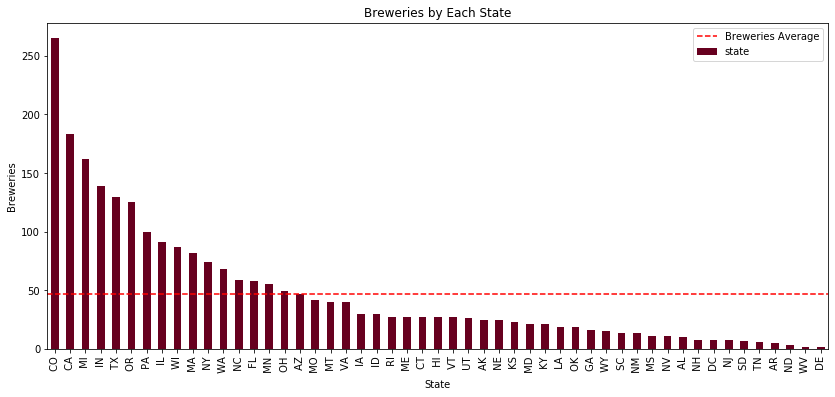

In [179]:
#Plot tha shows the amount of breweries by city and the mean.
plot = df.state.value_counts().plot(kind='bar', title="Breweries by Each State",figsize=(14,6), colormap='RdGy')
plot.set_xlabel('State')
plot.set_ylabel('Breweries')
mean_line = plot.axhline(df.state.value_counts().mean(), color='r', linestyle='--',label='Breweries Average')
plt.legend()

Text(0, 0.5, 'Breweries')

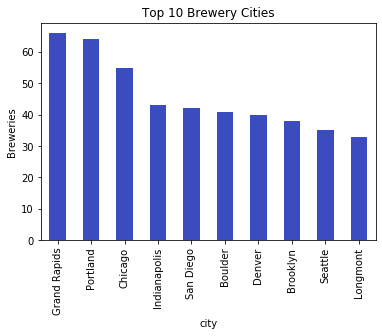

In [180]:
#Plot that shows the top 10 brewery cities
plot_2 = df.groupby(['city'])['brewer'].count().nlargest(10)
plot_2= plot_2.plot(kind='bar',title='Top 10 Brewery Cities', colormap='coolwarm')
plot_2.set_ylabel('Breweries')

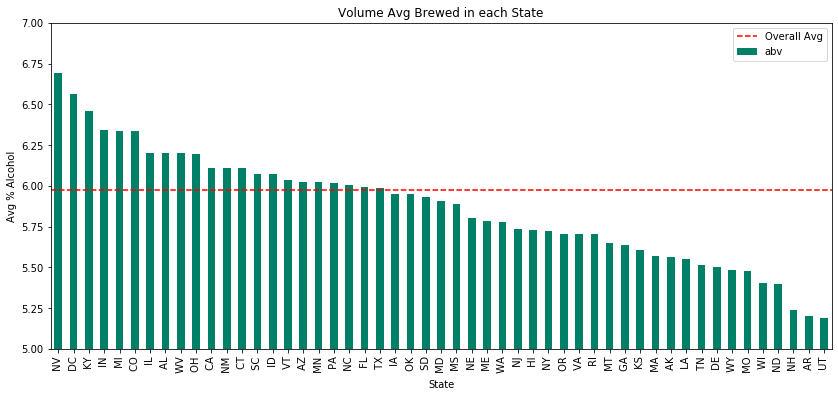

In [181]:
#Plot that shows the average alcoholic content by volume per State and National mean                                   
plot_3= (df.groupby('state')['abv'].mean().sort_values(ascending=False))*100
plot_3 = plot_3.plot(kind='bar',title="Volume Avg Brewed in each State", figsize=(14,6), ylim=(5, 7), colormap='summer') #ylim to start y axis on 5 and end on 7
plot_3.set_xlabel('State')
plot_3.set_ylabel('Avg % Alcohol')
mean_line1 = plot_3.axhline((df.abv.mean()*100), color='r', linestyle='--', label='Overall Avg')
plt.legend()

<Figure size 1440x720 with 0 Axes>

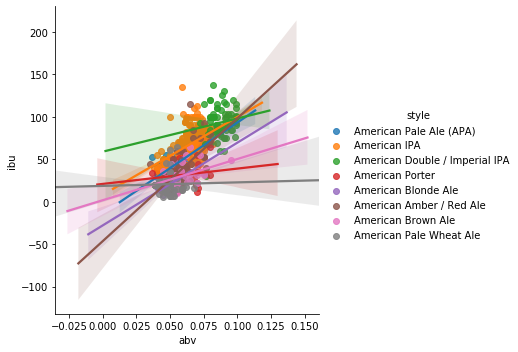

In [182]:
#This plot shows alcohol volume per bittering and colored by style to visualize linear relationships.
plot_4 =df.groupby('style').filter(lambda x: len(x) > 65) #This filter gets those styles that repeats more than 65 times.
plt.figure(figsize=(20,10)) 
ax = sns.lmplot(x='abv',y='ibu',data=plot_4, hue='style')
plt.show(ax)

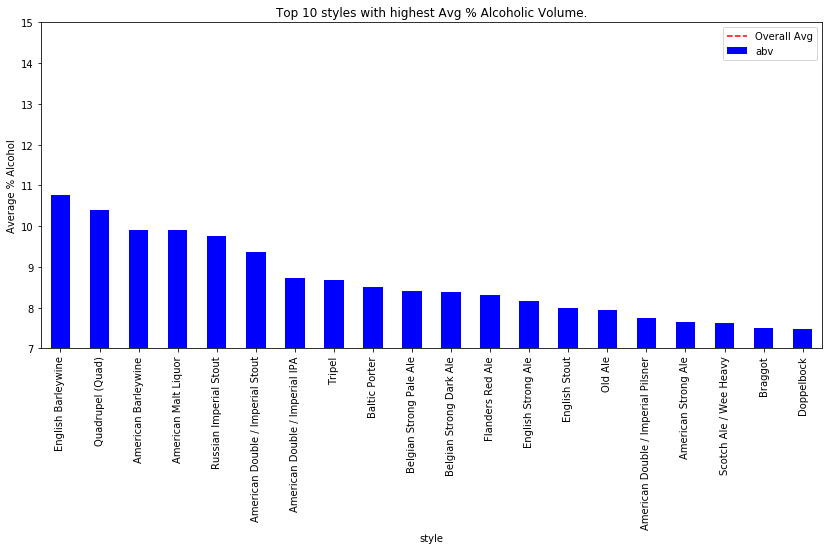

In [183]:
# Plot top 20 styles with  highesst Avg alcoholic volume
plot_5= (df.groupby('style')['abv'].mean().nlargest(20))*100
plot_5= plot_5.plot(kind='bar',title='Top 10 styles with highest Avg % Alcoholic Volume.',colormap='winter', figsize=(14,6), ylim=(7,15) ) #ylim to start y axis on 5 and end on 7
mean_line2 = plot_5.axhline((df.abv.mean()*100), color='r', linestyle='--', label='Overall Avg')
plot_5.set_ylabel('Average % Alcohol')
plt.legend()

Text(0, 0.5, 'Beers')

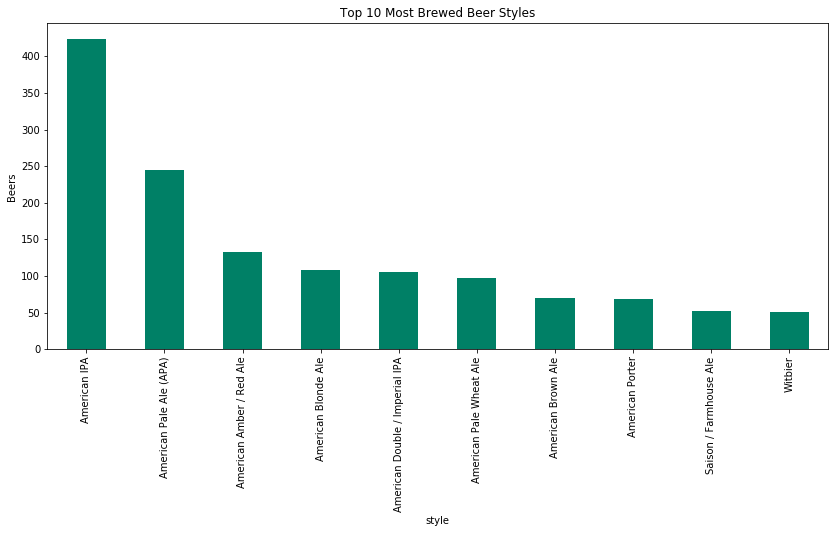

In [184]:
# Plot Top 10 most brewed styles
plot_6 = df.groupby('style')['beer'].count().nlargest(10)
plot_6  = plot_6.plot(kind='bar',title='Top 10 Most Brewed Beer Styles',colormap='summer', figsize=(14,6))
plot_6.set_ylabel('Beers')

(3.0, 0.0)

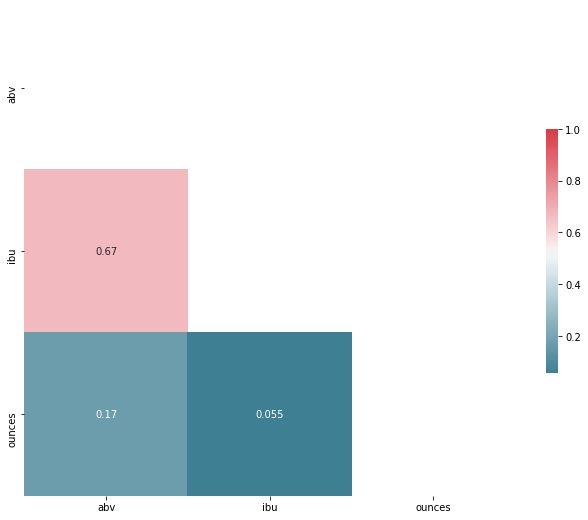

In [185]:
#Plotting a correlations
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr,annot= True, mask=mask, cmap=cmap,cbar_kws={"shrink": .5})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [186]:
# Encoding columns
df= pd.get_dummies(df,columns=['style','ounces','city','state','beer','brewer'])
df_nans= pd.get_dummies(df_nans_,columns=['style','ounces','city','state','beer','brewer'])

In [187]:
#We decided to predict missing data on ibu column and fill abv wit mean values.

df['abv'].fillna((df['abv'].mean()), inplace=True) # Filling abv columns with mean data on df
df_nans['abv'].fillna((df_nans['abv'].mean()), inplace=True) # Filling abv columns with mean data on df_nans
df_nans_['abv'].fillna((df_nans_['abv'].mean()), inplace=True) # Filling abv columns with mean data on df_nans

df = df.dropna(axis = 0) #drop rows with nans on df


In [188]:
# Leaving rows with nans values on df_nans
dnans = lambda df_nans: df_nans[df_nans.isnull().any(axis=1)]
df_nansx = dnans(df_nans)

orig_nans = lambda df_nans_: df_nans_[df_nans_.isnull().any(axis=1)]
df_nans_x = dnans(df_nans_)

In [189]:
df.head(3)

,abv,ibu,style_Abbey Single Ale,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,style_American Amber / Red Lager,style_American Barleywine,style_American Black Ale,style_American Blonde Ale,...,brewer_Wisconsin Brewing Company,brewer_Wiseacre Brewing Company,brewer_Witch's Hat Brewing Company,brewer_Wolf Hills Brewing Company,brewer_Wolverine State Brewing Company,brewer_Woodchuck Hard Cider,"brewer_Woodstock Inn, Station & Brewery",brewer_Wormtown Brewery,brewer_Worthy Brewing Company,brewer_Wynkoop Brewing Company
14,0.061,60.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0.099,92.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0.079,45.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
df_nansx.head(3)

,abv,ibu,style_Abbey Single Ale,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,style_American Amber / Red Lager,style_American Barleywine,style_American Black Ale,style_American Blonde Ale,...,brewer_Wisconsin Brewing Company,brewer_Wiseacre Brewing Company,brewer_Witch's Hat Brewing Company,brewer_Wolf Hills Brewing Company,brewer_Wolverine State Brewing Company,brewer_Woodchuck Hard Cider,"brewer_Woodstock Inn, Station & Brewery",brewer_Wormtown Brewery,brewer_Worthy Brewing Company,brewer_Wynkoop Brewing Company
0,0.050,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.066,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.071,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
%%time
#This is an attempt to get correlations after encoding and show values between 0.3 and 0.999

#Print Absolute value of correlations order by value.
absolute_value = df.corr().abs()
s = absolute_value.unstack()
so = s.sort_values(kind="quicksort")
so[~so.isnull()]
dfso=so[~so.isnull()]
dfso = so[~so.isnull()].where(dfso < 1).where(dfso > 0.3)
dfso[~dfso.isnull()]
sertest=dfso[~dfso.isnull()]
for serie in sertest.iteritems():

    for i in serie[0]:
            if i == 'ibu':
                print(serie)    

(('style_American Double / Imperial IPA', 'ibu'), 0.4631942652443251)
(('ibu', 'style_American Double / Imperial IPA'), 0.4631942652443251)
(('ibu', 'style_American IPA'), 0.5015567473388469)
(('style_American IPA', 'ibu'), 0.5015567473388469)
(('ibu', 'abv'), 0.6706214849969864)
(('abv', 'ibu'), 0.6706214849969864)
Wall time: 55.2 s


### Regression

In [191]:
X = df[df.columns.difference(['ibu'])] #All columns except ibu
y = df['ibu']

In [192]:
linreg = LinearRegression(n_jobs=-1)
split_size = 0.3
       
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=split_size, random_state=21)

linreg.fit(X_train,y_train)
predictionlr = linreg.predict(X_test)
scorelr = linreg.score(X_test, y_test)


In [193]:
X_nans = df_nansx[df_nansx.columns.difference(['ibu'])]
y_nans = df_nansx['ibu']

In [194]:
df_nans_x.isnull().sum()

abv          0
ibu       1005
style        5
ounces       0
city         0
state        0
beer         0
brewer       0
dtype: int64

In [198]:
df_nans_x = df_nans_x[:1005]

In [203]:
del df_nans_x ['ibu']

In [200]:
prediction = linreg.predict(X_nans)
df_nans_x['Predicted_ibu'] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [204]:
df_nans_x

,abv,style,ounces,city,state,beer,brewer,Predicted_ibu
0,0.050,American Pale Lager,12.0,Bend,OR,Pub Beer,10 Barrel Brewing Company,27.872096
1,0.066,American Pale Ale (APA),12.0,Gary,IN,Devil's Cup,18th Street Brewery,55.324370
2,0.071,American IPA,12.0,Gary,IN,Rise of the Phoenix,18th Street Brewery,78.273517
3,0.090,American Double / Imperial IPA,12.0,Gary,IN,Sinister,18th Street Brewery,97.408842
4,0.075,American IPA,12.0,Gary,IN,Sex and Candy,18th Street Brewery,78.273517
...,...,...,...,...,...,...,...,...
2401,0.042,Chile Beer,12.0,Denver,CO,Patty's Chile Beer,Wynkoop Brewing Company,27.705621
2402,0.082,American Strong Ale,12.0,Denver,CO,Colorojo Imperial Red Ale,Wynkoop Brewing Company,32.637017
2403,0.055,Pumpkin Ale,12.0,Denver,CO,Wynkoop Pumpkin Ale,Wynkoop Brewing Company,36.184333
2404,0.075,American Stout,12.0,Denver,CO,Rocky Mountain Oyster Stout,Wynkoop Brewing Company,28.131901


### Playing With Cross Validation / Prediction

In [205]:
%%time
splits_test = list(range(2,16)) #-->Created a list range from 5-30 to be used in Kfold method
lr = LinearRegression(n_jobs=-1)
cross_val_scores = []
cross_val_scores_m = []

for sp in splits_test:
    kf = KFold(n_splits=sp)
    splits = list(kf.split(X_train))
    

    # this will get the index values increasing stepwise 
    X_train = X_train.reset_index()
    y_train = y_train.reset_index()

    # this will get rid of the 'index' column that pops up after you reset the index
    X_train = X_train.drop('index', axis=1)
    y_train = y_train.drop('index', axis=1)


    for test_idx, val_idx in kf.split(X_train):
        lr.fit(X_train.iloc[test_idx], y_train.iloc[test_idx])
        score = lr.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
        cross_val_scores.append((sp,score))

        
sc_values = pd.DataFrame(cross_val_scores, columns =['Ks','Score']) 
kscores_mean = sc_values.groupby('Ks')['Score'].mean()
print (kscores_mean.sort_values(ascending=False), "\n\n")
print ("k=",kscores_mean.idxmax(),"has the max score= ",kscores_mean.max())

Ks
11    0.717499
15    0.715887
7     0.714238
9     0.713257
6     0.712901
12    0.712215
5     0.711899
8     0.711870
14    0.710704
4     0.710595
10    0.707499
3     0.706892
13    0.700562
2     0.683433
Name: Score, dtype: float64 


k= 11 has the max score=  0.7174992499467264
Wall time: 35.9 s


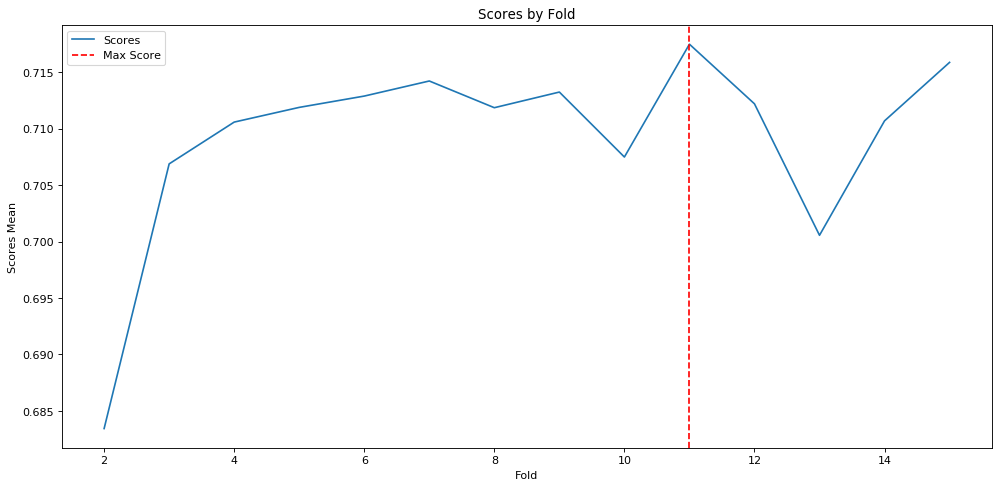

In [206]:
#Graphing Scores
figure(figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Scores by Fold')
plt.plot(splits_test, kscores_mean, label = 'Scores')
plt.axvline(kscores_mean.idxmax(), color='r', linestyle='--', label = 'Max Score') #Line on Highest score
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Scores Mean')
plt.show()

In [242]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X_test, y_test , cv=5)

predicted

array([ 38.88169374,  14.51513279,  41.10795061,  95.54279752,
        73.89020623,  20.3279289 ,  42.94204039,  76.94867332,
        23.80849058,  25.16240844,  23.61009593,  72.64632899,
        66.35100412,  39.95770015,  65.37920797,   6.2631971 ,
        39.10347719,  20.73231666,  34.52182272,  64.13346651,
        67.83076404,  39.84806074,  24.8533959 ,  33.20742609,
        28.19099806,  52.80410037,  39.45652995,  30.92975559,
        62.79003978,  18.27847646,  35.35361289,  50.38366847,
        38.13022418,  33.3198035 ,  62.31013624,  29.75026515,
        23.03419146, 104.25023347,  20.96599984,  38.63943825,
        19.51124555,  51.56231585,  27.53003046,  32.10044548,
        10.35317941,  30.96896761,  99.89469196,  20.56523623,
        15.47488055,  17.84511992,  18.8706074 ,  39.25010989,
        66.21854167,  28.42113235,  39.50512205,  17.62430825,
        25.78959782,  43.91189815,  63.05167105,  28.36770238,
        59.87683775,  -1.01765065,  39.48734936,  24.38

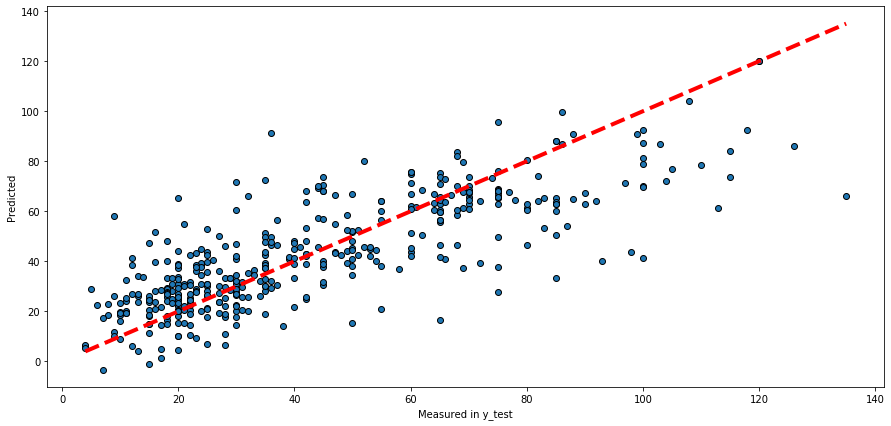

In [245]:
#Graphing Cross Validation Predictions Errors
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0)) #Scatter predicted (y) values 
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4,) 
ax.set_xlabel('Measured in y_test')
ax.set_ylabel('Predicted')
plt.show()

###  Playing with Grid Search

In [210]:
#Grid Search Parameters
grid_params = {
    'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 5, 10, 25, 50]
}

In [211]:
rfc = RandomForestRegressor(n_jobs=-1)

In [212]:
X = df[df.columns.difference(['ibu'])]
y= df[['ibu']]

In [215]:
%%time
#Running Grid Search
Grid = GridSearchCV(estimator=rfc, cv=5, param_grid=grid_params,n_jobs=-1)
Grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Wall time: 56.6 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': [0.2, 0.3, 0.4, 0.5

In [216]:
Grid.best_params_

{'max_features': 0.2, 'min_samples_leaf': 1, 'n_estimators': 100}

In [217]:
Grid.cv_results_

{'mean_fit_time': array([0.28546572, 0.80558348, 2.09127307, 1.27608871, 0.73836441,
        1.13405652, 1.00562706, 0.77057247, 0.78257751, 0.62474008,
        0.66114855, 0.52871876, 0.35467997, 0.42689524, 0.39368887,
        0.6531476 , 1.31489735, 1.55415144, 0.85539322, 0.90060387,
        1.13705654, 0.88500009, 0.80458231, 1.0128284 , 0.61173773,
        0.76857481, 0.86499496, 0.46330357, 0.43909869, 0.73456683,
        0.60553622, 1.22827744, 1.75419679, 1.19106874, 1.08964648,
        1.25828462, 0.83218784, 0.59193397, 1.1230536 , 0.73136463,
        0.92840929, 0.76237216, 0.58453193, 0.77517443, 0.74076762,
        0.48530874, 1.49833837, 2.1920959 , 1.53354692, 1.3829133 ,
        1.47453327, 0.80398111, 0.91300712, 1.23707938, 0.74516835,
        1.03583369, 1.13785758, 0.60893865, 0.7259644 , 0.73536596,
        0.7943789 , 1.35050535, 2.07866998, 1.16566348, 1.22567692,
        1.64977388, 1.25888405, 0.96721807, 0.94181271, 0.51691637,
        1.1658628 , 1.31949801,

In [219]:
grid_results = pd.DataFrame(Grid.cv_results_)
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.285466,0.065664,0.521518,0.264722,0.2,1,10,"{'max_features': 0.2, 'min_samples_leaf': 1, '...",0.778362,0.688507,0.785502,0.771803,0.708138,0.746476,0.040042,18
1,0.805583,0.263830,1.321500,0.238954,0.2,1,50,"{'max_features': 0.2, 'min_samples_leaf': 1, '...",0.804408,0.713886,0.811206,0.778481,0.740002,0.769618,0.037446,2
2,2.091273,0.081629,0.271262,0.083357,0.2,1,100,"{'max_features': 0.2, 'min_samples_leaf': 1, '...",0.797947,0.719115,0.808505,0.788006,0.747508,0.772225,0.033662,1
3,1.276089,0.349377,0.548728,0.453416,0.2,5,10,"{'max_features': 0.2, 'min_samples_leaf': 5, '...",0.777086,0.654548,0.752084,0.721958,0.676901,0.716550,0.045576,39
4,0.738364,0.271883,0.438699,0.243571,0.2,5,50,"{'max_features': 0.2, 'min_samples_leaf': 5, '...",0.777613,0.670461,0.770538,0.731017,0.667935,0.723562,0.047127,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1.026832,0.289996,0.452702,0.193374,0.8,25,50,"{'max_features': 0.8, 'min_samples_leaf': 25, ...",0.660451,0.586646,0.721982,0.665791,0.581779,0.643370,0.052900,70
101,1.309296,0.108262,0.474108,0.099406,0.8,25,100,"{'max_features': 0.8, 'min_samples_leaf': 25, ...",0.657415,0.586403,0.716832,0.664582,0.584094,0.641901,0.050592,71
102,0.861194,0.156111,0.458505,0.186738,0.8,50,10,"{'max_features': 0.8, 'min_samples_leaf': 50, ...",0.571474,0.535080,0.594293,0.558916,0.493090,0.550621,0.034517,89
103,1.113851,0.394852,0.379487,0.081471,0.8,50,50,"{'max_features': 0.8, 'min_samples_leaf': 50, ...",0.582410,0.530297,0.643071,0.573752,0.492307,0.564431,0.050913,82


In [220]:
grid_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.091273,0.081629,0.271262,0.083357,0.2,1,100,"{'max_features': 0.2, 'min_samples_leaf': 1, '...",0.797947,0.719115,0.808505,0.788006,0.747508,0.772225,0.033662,1
1,0.805583,0.263830,1.321500,0.238954,0.2,1,50,"{'max_features': 0.2, 'min_samples_leaf': 1, '...",0.804408,0.713886,0.811206,0.778481,0.740002,0.769618,0.037446,2
31,1.228277,0.156412,1.169467,0.071618,0.4,1,50,"{'max_features': 0.4, 'min_samples_leaf': 1, '...",0.789941,0.704033,0.807426,0.797426,0.735911,0.766948,0.040061,3
17,1.554151,0.264599,0.680155,0.191592,0.3,1,100,"{'max_features': 0.3, 'min_samples_leaf': 1, '...",0.794658,0.706946,0.804516,0.781224,0.746865,0.766848,0.035767,4
32,1.754197,0.194488,0.632143,0.256906,0.4,1,100,"{'max_features': 0.4, 'min_samples_leaf': 1, '...",0.798355,0.705568,0.802850,0.790924,0.734285,0.766404,0.039218,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0.439099,0.102557,0.254858,0.159813,0.3,50,50,"{'max_features': 0.3, 'min_samples_leaf': 50, ...",0.431458,0.377406,0.418390,0.449156,0.396563,0.414578,0.025299,101
27,0.463304,0.096573,0.288265,0.076927,0.3,50,10,"{'max_features': 0.3, 'min_samples_leaf': 50, ...",0.388870,0.351715,0.385056,0.411046,0.368874,0.381094,0.019922,102
12,0.354680,0.053047,0.292668,0.057898,0.2,50,10,"{'max_features': 0.2, 'min_samples_leaf': 50, ...",0.440204,0.317751,0.307022,0.240239,0.337479,0.328620,0.064696,103
13,0.426895,0.019306,0.169040,0.017531,0.2,50,50,"{'max_features': 0.2, 'min_samples_leaf': 50, ...",0.293943,0.279773,0.368015,0.370608,0.255859,0.313640,0.047041,104


In [221]:
grid_results.groupby('param_n_estimators')['mean_test_score'].mean()

param_n_estimators
10     0.646420
50     0.654717
100    0.655900
Name: mean_test_score, dtype: float64

In [222]:
grid_results.groupby('param_max_features')['mean_test_score'].mean()

param_max_features
0.2    0.586418
0.3    0.632477
0.4    0.659478
0.5    0.669175
0.6    0.671827
0.7    0.674217
0.8    0.672827
Name: mean_test_score, dtype: float64

### Playing with Pipeline

In [233]:
#Will use Standard Scaler and Lasso regression for pipe
sc = StandardScaler()
lasso = Lasso()

In [239]:
#Creating the pipline 
pipe = make_pipeline(sc, lasso)
pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [240]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [241]:
pipe.predict(X)

array([45.57619791, 73.85243391, 42.89354397, ..., 48.1816216 ,
       37.60238001, 41.38028126])